In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from hydra import initialize, compose
from rdkit import Chem
from collections import defaultdict
from itertools import accumulate
from ergochemics.mapping import rc_to_nest
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
from cgr.ml import sep_aidx_to_bin_label
import yaml
from ast import literal_eval

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

from sklearn.calibration import CalibrationDisplay

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

mlflow.set_tracking_uri(f"file://{cfg.mlruns}")

In [2]:
def get_reaction_center(am_rxn: str) -> list[list[list[int]], list[list[int]]]:
    sides = [elt.split('.') for elt in am_rxn.split('>>')]
    amn_to_midx_aidx = [] # Atom map num to mol idx, atom idx for lhs, rhs
    adj_mats = []
    for side in sides:
        tmp = {}
        for midx, smi in enumerate(side):
            mol = Chem.MolFromSmiles(smi)
            for atom in mol.GetAtoms():
                tmp[atom.GetAtomMapNum()] = (midx, atom.GetIdx())
        
        amn_to_midx_aidx.append(tmp)

        block_smi = ".".join(side)
        block_mol = Chem.MolFromSmiles(block_smi)
        block_aidx_to_amn = {atom.GetIdx(): atom.GetAtomMapNum() for atom in block_mol.GetAtoms()}
        A = Chem.GetAdjacencyMatrix(mol=block_mol, useBO=True)
        srt_idx = sorted([i for i in range(A.shape[0])], key=lambda x : block_aidx_to_amn[x])
        A = A[:, srt_idx][srt_idx]
        adj_mats.append(A)

    D = np.abs(adj_mats[1] - adj_mats[0])
    if len(amn_to_midx_aidx[0].keys() ^ amn_to_midx_aidx[1].keys()) != 0:
        raise ValueError("LHS and RHS atom maps do not perfectly intersect")

    rc_amns = np.flatnonzero(D.sum(axis=1)) + 1
    
    reaction_center = [[[] for _ in range(len(side))] for side in sides]
    for amn in rc_amns:
        for side_idx, lookup in enumerate(amn_to_midx_aidx):
            midx, aidx = lookup[amn]
            reaction_center[side_idx][midx].append(aidx)

    return reaction_center

def get_min_dist_to_rc(am_rxn: str, rc: list[list[list[int]], list[list[int]]]) -> list[list[list[int]], list[list[int]]]:
    mols = [[Chem.MolFromSmiles(elt) for elt in side.split('.')] for side in am_rxn.split('>>')]
    min_dists = [[], []]
    for i, side_rc in enumerate(rc):
        for mol, rc in zip(mols[i], side_rc):
            for atom in mol.GetAtoms():
                aidx = atom.GetIdx()
                min_dist = min(len(Chem.GetShortestPath(mol, aidx, rcidx)) - 1 if aidx != rcidx else 0 for rcidx in rc)

                min_dists[i].append(min_dist)
    return [np.array(elt).reshape(-1, 1) for elt in min_dists]


In [3]:
experiment_name = "outer_splits"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
else:
    print(f"Experiment '{experiment_name}' not found.")

In [4]:
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.epoch,metrics.test_recall,metrics.train_loss,metrics.test_loss,...,params.study_version,params.init_lr,params.training/max_epochs,params.data/outer_splitter/shuffle,params.model/mp_depth,tags.source,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name
0,4ef541b0e98f4ac5940b3a7491343b53,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:51:47.409000+00:00,2025-05-14 16:55:31.896000+00:00,7.0,0.790553,0.089376,0.116239,...,5,0.0001,7,True,4,train.py,LOCAL,spn1560,youthful-skink-802,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...
1,ea7fc676bc224391adac4effa781eecf,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:59.104000+00:00,2025-05-14 16:46:57.102000+00:00,9.0,0.709589,0.090822,0.160410,...,0,0.0001,9,True,3,train.py,LOCAL,spn1560,brawny-hawk-294,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...
2,06179ac0c9b742e0b75ea920b59bc2a2,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:54.723000+00:00,2025-05-14 16:46:31.126000+00:00,8.0,0.770664,0.092075,0.110132,...,0,0.0001,8,True,4,train.py,LOCAL,spn1560,rumbling-kit-889,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...
3,690e593ce2ea492987e1d7c61849503b,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:52.627000+00:00,2025-05-14 16:45:35.026000+00:00,5.0,0.965295,0.200481,0.119013,...,0,0.0001,5,True,4,train.py,LOCAL,spn1560,rogue-vole-197,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...
4,e9df2c14ceca475b95cb3165faef8959,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:52.627000+00:00,2025-05-14 16:50:25.655000+00:00,18.0,0.808537,0.109731,0.233754,...,0,0.0001,18,True,4,train.py,LOCAL,spn1560,adorable-toad-359,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...


In [ ]:
# Copy configs to conf dir to train production model
for i, row in df.iterrows():
    fn = f"outer_split_{row['params.data/outer_split_idx']}.yaml"
    out_path = Path(cfg.configs) / "full" / fn

    config = defaultdict(dict)
    for k, v in row.items():
        if k.startswith("params.") and "/" in k:
            k_out, k_in, *_ = k.removeprefix("params.").split("/")
            try:
                config[k_out][k_in] = literal_eval(v)
            except ValueError:
                config[k_out][k_in] = v


    with open(out_path, "w") as f:
        yaml.dump(dict(config), f)
    
    print(f"Saving config to: {out_path}")

Saving config to: /home/stef/cgr/configs/full/outer_split_0.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_1.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_2.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_3.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_4.yaml


In [5]:
df.sort_values(
    by=["metrics.test_auprc"],
    ascending=False,
    inplace=True,
)
df[[*[col for col in df.columns if col.startswith("metrics.") or col.startswith("params.")]]].head(10)

,metrics.train_loss,metrics.test_auprc,metrics.test_recall,metrics.epoch,metrics.test_acc,metrics.test_loss,metrics.test_auroc,metrics.test_precision,params.use_study,params.data/split_strategy,...,params.study_name,params.training/pw_scl,params.max_lr,params.training/max_epochs,params.data/outer_splitter/n_splits,params.training/init_lr,params.model/mp_d_h,params.model/pred_head_d_hs,params.model/pred_head_name,params.training/batch_size
3,0.200481,0.948556,0.965295,5.0,0.963204,0.119013,0.991205,0.754520,True,random_rule_split,...,outer_split_3_strategy_random_rule_split_obj_v...,0.2899307546477962,0.0001,5,5,0.0001,286,"[156, 161, 111]",ffn,102
0,0.089376,0.939413,0.790553,7.0,0.952870,0.116239,0.979767,0.922377,True,random_rule_split,...,outer_split_0_strategy_random_rule_split_obj_v...,0.12624714905305276,0.0001,7,5,0.0001,211,"[181, 103]",ffn,102
2,0.092075,0.912443,0.770664,8.0,0.964769,0.110132,0.977716,0.906544,True,random_rule_split,...,outer_split_2_strategy_random_rule_split_obj_v...,0.1564945312174881,0.0001,8,5,0.0001,200,"[130, 196, 104]",ffn,101
4,0.109731,0.899109,0.808537,18.0,0.947999,0.233754,0.971402,0.797780,True,random_rule_split,...,outer_split_4_strategy_random_rule_split_obj_v...,0.33502808999629763,0.0001,18,5,0.0001,240,"[200, 144, 156]",ffn,115
1,0.090822,0.876712,0.709589,9.0,0.941155,0.160410,0.957251,0.870209,True,random_rule_split,...,outer_split_1_strategy_random_rule_split_obj_v...,0.14005412753779029,0.0001,9,5,0.0001,223,"[179, 123]",ffn,106


In [6]:
row = df.iloc[0]
run_id = row.run_id
experiment_id = row.experiment_id

In [7]:
pred_df = pd.read_parquet(
    Path(row.artifact_uri.replace("file:///home/spn1560/coarse-grain-rxns", "..")) / "predictions.parquet"
)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,10,0,0.0,0.352157
1,10,1,1.0,0.936013
2,10,2,1.0,0.665277
3,10,3,0.0,0.665277
4,10,4,1.0,0.922557


In [ ]:
preds = []
for _, row in df[df['params.objective'] == 'val_f1'].iterrows():
    preds.append(
        pd.read_parquet(
            Path(row['artifact_uri'].replace("file:///home/spn1560/coarse-grain-rxns", "..")) / "predictions.parquet"
        )
    )

pred_df = pd.concat(preds, ignore_index=True)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,10,0,0.0,0.352157
1,10,1,1.0,0.936013
2,10,2,1.0,0.665277
3,10,3,0.0,0.665277
4,10,4,1.0,0.922557


In [ ]:
full = pd.read_parquet(
    Path(cfg.raw_data) / "mapped_sprhea_240310_v3_mapped_no_subunits_x_mechanistic_rules.parquet"
)
full["template_aidxs"] = full["template_aidxs"].apply(rc_to_nest)
full["reaction_center"] = full["am_smarts"].apply(get_reaction_center) # Get the actual reaction center from the atom mapped reactions
full["min_dist_to_rc"] = full.apply(lambda x: get_min_dist_to_rc(x.am_smarts, x.reaction_center)[0], axis=1) # Get min dist to reaction center for lhs
full["binary_label"] = full.apply(lambda x: sep_aidx_to_bin_label(x.am_smarts, x.template_aidxs)[0], axis=1) # Convert aidxs to binary labels for block mol
full.head()

,rxn_id,smarts,am_smarts,rule,reaction_center,rule_id,template_aidxs,min_dist_to_rc,binary_label
0,1,CC(O)C(O)C(O)C(O)C(=O)O>>O.CC(O)C(O)CC(=O)C(=O)O,[CH3:11][CH:9]([OH:12])[CH:8]([OH:10])[CH:7]([...,[O&D1&v2&H0&0*&!R:1]=[C&D3&v4&H0&0*&!R&z2:2](-...,"[[[6, 11, 9, 10, 7, 8, 5]], [[0], [9, 8, 10, 6...",841,"(((10, 9, 11, 7, 8, 5, 6),), ((0,), (0, 1, 2, ...","[[3], [2], [3], [1], [2], [0], [0], [0], [0], ...","[[0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1...."
1,10,O=P(O)(O)OP(=O)(O)O.CCCCCCCCCCCC(=O)OP(=O)(O)O...,[O:10]=[P:1]([OH:2])([OH:11])[O:3][P:4](=[O:5]...,[*:1](~[O&D1&v2&H1&0*&!R:2])~[*:3]~[*:4](~[O&D...,"[[[8], [14, 13]], [[18, 15], [13]]]",632,"(((1, 2, 4, 5, 6, 7, 8), (14, 16, 13)), ((0, 1...","[[4], [3], [4], [4], [2], [1], [2], [2], [0], ...","[[0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1...."
2,100,*C(=O)OCC(COP(=O)(O)OC1C(O)C(OP(=O)(O)O)C(O)C(...,[*:30][C:27](=[O:31])[O:25][CH2:23][CH:22]([CH...,[*:1](~[O&D2&v2&H0&0*&!R:2]-[P&D4&v5&H0&0*&!R:...,"[[[16, 17], [0]], [[16], [1, 3]]]",813,"(((15, 16, 17, 19, 13, 14), (0,)), ((0, 1, 2, ...","[[12], [11], [12], [10], [9], [8], [7], [6], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
3,10001,Nc1c(NCC(O)C(O)C(O)CO)[nH]c(=O)[nH]c1=O.Cc1cc2...,[NH2:25][c:26]1[c:27]([NH:29][CH2:36][CH:37]([...,[N&D1&v3&H2&0*&!R:1]-[c&D3&v4&H0&0*&R&z1:2]:[c...,"[[[0, 1, 2, 3], [2, 3, 23, 24, 25, 1]], [[0, 1...",338,"(((0, 1, 2, 3, 13), (1, 2, 3, 4, 5, 12, 11, 9,...","[[0], [0], [0], [0], [1], [2], [3], [3], [4], ...","[[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0...."
4,10008,O.O=[N+]([O-])c1ccc(OP(=O)(O)O)cc1>>O=P(O)(O)O...,[OH2:5].[O:14]=[N+:13]([O-:15])[c:12]1[cH:10][...,[O&D0&v2&H2&0*&!R:1].[O&D2&v2&H0&0*&!R:2]-[P&D...,"[[[0], [11, 8, 9, 7]], [[0, 1, 3, 4], [7]]]",585,"(((0,), (7, 8, 9, 10, 11)), ((0, 1, 2, 3, 4), ...","[[0], [6], [5], [6], [4], [3], [2], [1], [0], ...","[[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."


In [71]:
min_dist_map = dict(zip(full["rxn_id"].astype(int), full["min_dist_to_rc"]))
rule_id_map = dict(zip(full["rxn_id"].astype(int), full["rule_id"]))
pred_df["rule_id"] = pred_df["rxn_id"].map(rule_id_map)
pred_df["min_dist_to_rc"] = None
for k, v in min_dist_map.items():
    pred_df.loc[pred_df["rxn_id"] == k, "min_dist_to_rc"] = v.flatten()

pred_df.head()

,rxn_id,aidx,y,y_pred,min_dist_to_rc,rule_id
0,10,0,0.0,0.352157,4,632
1,10,1,1.0,0.936013,3,632
2,10,2,1.0,0.665277,4,632
3,10,3,0.0,0.665277,4,632
4,10,4,1.0,0.922557,2,632


In [10]:
bad_ids = set()
for _, row in full.iterrows():
    templates = row["template_aidxs"][0]
    rcs = row["reaction_center"][0]

    for template, rc in zip(templates, rcs):
        if len(set(rc) - set(template)) != 0:
            bad_ids.add(row["rxn_id"])
print(bad_ids)

{'12818', '3555', '5872', '3707', '1101', '6303', '7054', '16263', '6020', '8971'}


In [11]:
continuous_rxn_ids = []
for _, row in full.iterrows():
    continuous_rxn_ids.append(
        np.repeat(int(row["rxn_id"]), row["binary_label"].shape[0]).reshape(-1, 1)
    )

continuous_rxn_ids = np.vstack(continuous_rxn_ids)

y = np.vstack(full["binary_label"])
min_dist_rc = np.vstack(full["min_dist_to_rc"])
Rs = [0, 1, 2, 3, 4]
rcr_preds = {R: (min_dist_rc <= R).astype(np.int32) for R in Rs}
recall_from_rcr = [recall_score(y, rcr_preds[R]) for R in Rs]
precision_from_rcr = [precision_score(y, rcr_preds[R]) for R in Rs]
recall_from_rcr, precision_from_rcr

([0.5273371670807345,
  0.7103841275908198,
  0.8372800083392693,
  0.9088066158202888,
  0.965305165134905],
 [0.9993415204293287,
  0.6636855004950576,
  0.4980725307206565,
  0.4035082306113948,
  0.33884226960042935])

In [12]:
bad_ids = np.unique(continuous_rxn_ids[(rcr_preds[0] - y == 1)])
bad_ids

array([ 1101,  3555,  3707,  5872,  6020,  6303,  7054,  8971, 12818,
       16263])

In [13]:
row = full[full["rxn_id"] == '10024']
row

,rxn_id,smarts,am_smarts,rule,reaction_center,rule_id,template_aidxs,min_dist_to_rc,binary_label
10,10024,CNCC(O)c1ccccc1.Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=...,[CH3:1][NH:28][CH2:29][CH:30]([OH:31])[c:32]1[...,[C&D1&v4&H3&0*&!R&z1:1]-[N&D2&v3&H1&0*&!R:2].[...,"[[[0, 1], [14]], [[0, 1], [0]]]",42,"(((0, 1), (14,)), ((0, 1), (0,)))","[[0], [0], [1], [2], [3], [3], [4], [5], [6], ...","[[1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0...."


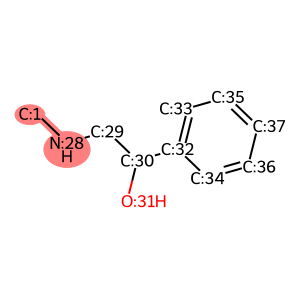

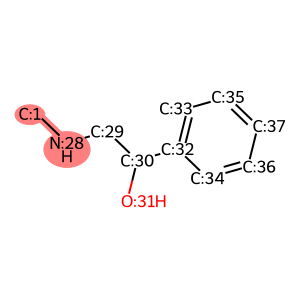

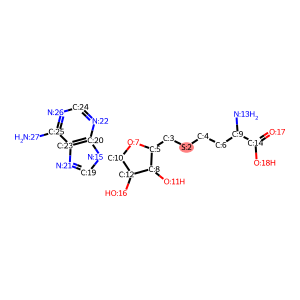

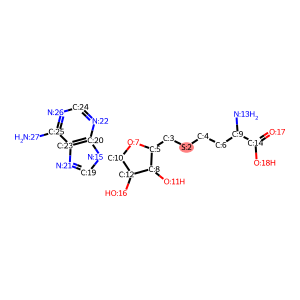

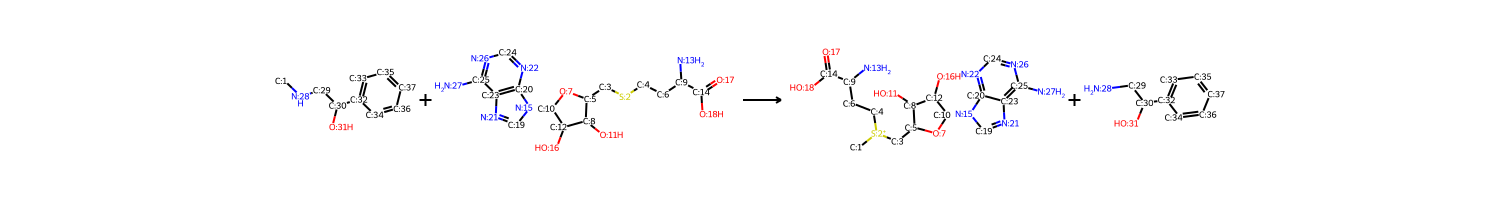

In [14]:
am_rxn = row["am_smarts"].values[0]
lhs_mols = [Chem.MolFromSmiles(elt) for elt in am_rxn.split('>>')[0].split('.')]
for i, mol in enumerate(lhs_mols):
    template = row["template_aidxs"].values[0][0][i]
    rc = row["reaction_center"].values[0][0][i]
    display(SVG(draw_molecule(lhs_mols[i], highlight_atoms=template, size=(300, 300))))
    display(SVG(draw_molecule(lhs_mols[i], highlight_atoms=rc, size=(300, 300))))
display(SVG(draw_reaction(am_rxn)))

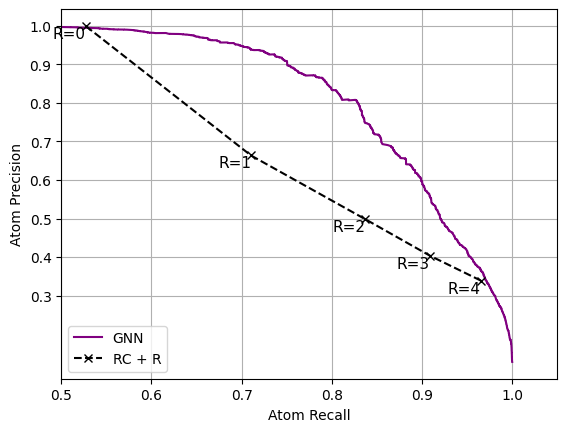

In [85]:
# RC + R stats
r_labels = [f"R={i}" for i in range(len(recall_from_rcr))]

precision, recall, thresholds = precision_recall_curve(pred_df.y, pred_df.y_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple', label="GNN")
ax.plot(recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.set_xticks(np.arange(0.4, 1.05, 0.1))
ax.set_yticks(np.arange(0.3, 1.05, 0.1))
ax.set_xlim(0.5, 1.05)
ax.set_xlabel("Atom Recall")
ax.set_ylabel("Atom Precision")
for r, p, label in zip(recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.show()

In [ ]:
rxn_recall_from_rcr = []
for R in Rs:
    preds = rcr_preds[R]
    rxn_recovery_indicator = []
    for rxn_id in np.unique(continuous_rxn_ids):
        if (preds[continuous_rxn_ids == rxn_id] - y[continuous_rxn_ids == rxn_id] >= 0).all():
            rxn_recovery_indicator.append(1)
        else:
            rxn_recovery_indicator.append(0)
    
    rxn_recall_from_rcr.append(sum(rxn_recovery_indicator) / len(rxn_recovery_indicator))

rxn_recall = []
ds = 1_000
for dt in thresholds[::ds]:
    rxn_recovery_indicator = []
    for rxn_id, group in pred_df.groupby("rxn_id"):
        preds = (group.y_pred >= dt).astype(np.int32).to_numpy()
        ytrue = group.y.to_numpy()
        if (preds - ytrue >= 0).all():
            rxn_recovery_indicator.append(1)
        else:
            rxn_recovery_indicator.append(0)

    rxn_recall.append(sum(rxn_recovery_indicator) / len(rxn_recovery_indicator))

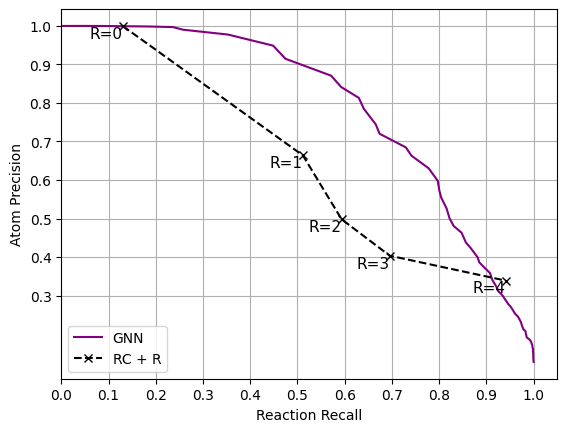

In [47]:
fig, ax = plt.subplots()
ax.plot(rxn_recall, precision[::ds], color='purple', label="GNN")
ax.plot(rxn_recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.set_xticks(np.arange(0.0, 1.05, 0.1))
ax.set_yticks(np.arange(0.3, 1.05, 0.1))
ax.set_xlim(0.0, 1.05)
ax.set_xlabel("Reaction Recall")
ax.set_ylabel("Atom Precision")
for r, p, label in zip(rxn_recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.show()

/tmp/ipykernel_54796/601511155.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_R = pred_df.groupby("min_dist_to_rc").apply(


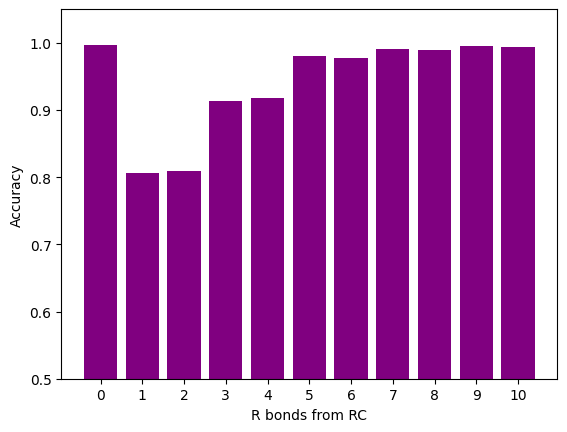

In [84]:
acc_by_R = pred_df.groupby("min_dist_to_rc").apply(
    lambda x: accuracy_score(x.y, x.y_pred >= 0.5)
).iloc[:11]

fig, ax = plt.subplots()
ax.bar(acc_by_R.index, acc_by_R.values, color='purple')
ax.set_xticks(acc_by_R.index)
ax.set_xlabel("R bonds from RC")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.5, 1.05)
plt.show()

/tmp/ipykernel_54796/1932033912.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_by_rule = pred_df.groupby("rule_id").apply(


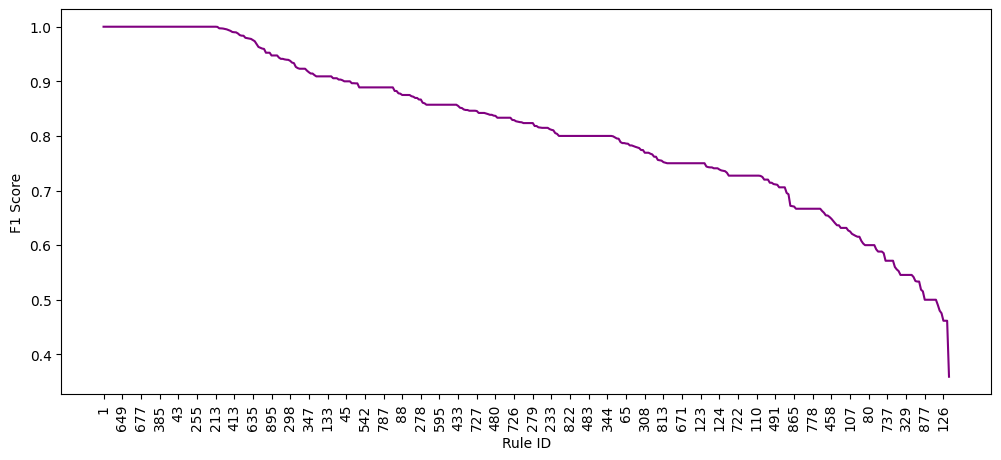

In [ ]:
f1_by_rule = pred_df.groupby("rule_id").apply(
    lambda x: f1_score(x.y, x.y_pred >= 0.5)
).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(f1_by_rule.values, color='purple')
ax.set_xticks(np.arange(0, len(f1_by_rule), 10))
ax.set_xticklabels(f1_by_rule.index[::10], rotation=90)
ax.set_xlabel("Rule ID")
ax.set_ylabel("F1 Score")
plt.show()

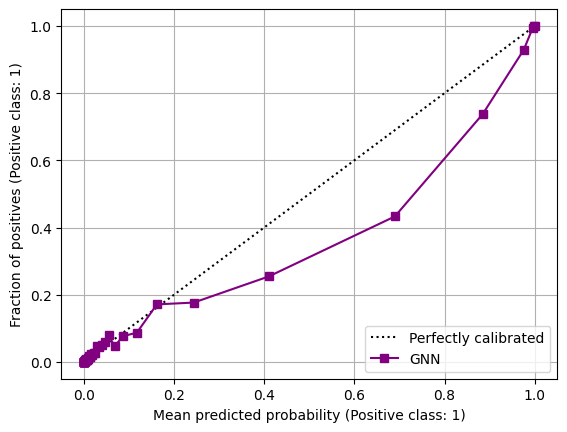

In [16]:
disp = CalibrationDisplay.from_predictions(
    pred_df.y,
    pred_df.y_pred,
    strategy="quantile",
    n_bins=50,
    name="GNN",
    color='purple',
)
plt.grid()
plt.show()